<a href="https://colab.research.google.com/github/Fahrulmuhamad/MyScript/blob/master/Biomass_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biomass Prediction Model

###Python Library
Load and Install required Python Library
several python library has been installed on google collab such as numpy, pandas, geopandas, matplotlib, gdal and scikit learn

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Input and Output Parameters
Set the parameter of input and output that stored in Google Drive. Please prepare the post-processend satellite image with several predictor Bands as well as the Training and Testing Sample

In [3]:
# define inputs
inpRaster = '/content/drive/MyDrive/PASCO/00_Preliminary Biomass Model Using Google Embedded Image/Input/Google_Embedded_RMJ.tif'
outRaster = '/content/drive/MyDrive/PASCO/00_Preliminary Biomass Model Using Google Embedded Image/Output/output_RMJ.tif'
outCluster = '/content/drive/MyDrive/PASCO/00_Preliminary Biomass Model Using Google Embedded Image/Output/output_RMJ_cluster.tif'
gdf_train = gpd.read_file('/content/drive/MyDrive/PASCO/00_Preliminary Biomass Model Using Sentinel 2/Input/sample_training_Sentinel2.shp')
gdf_test = gpd.read_file('/content/drive/MyDrive/PASCO/00_Preliminary Biomass Model Using Sentinel 2/Input/sample_validation_Sentinel2.shp')

Define the predictor band based on the satellite imagery band name used as the predictor of model

In [4]:
predictor_bands = ['NDVI','SAVI','EVI2','FWEI','GLI','CVI']
prediction_band = 'CAGB'
x_train = gdf_train[predictor_bands]
y_train = gdf_train[prediction_band]
x_test = gdf_test[predictor_bands]
y_test = gdf_test[prediction_band]

Combine Historical data and Validation Data to Refitting Model (If Needed)

In [5]:
x_combined_train = pd.concat([x_train, x_test], ignore_index=True)
y_combined_train = pd.concat([y_train, y_test], ignore_index=True)
x_train = x_combined_train
y_train = y_combined_train

###Open Raster
Open the raster image using GDAL library and reshape the raster as an array to ease the data analysis using common library such as scikit learn

In [6]:
# open raster using GDAL
ds = gdal.Open(inpRaster, gdal.GA_ReadOnly)

/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [7]:
# get raster info
rows = ds.RasterYSize
cols = ds.RasterXSize
bands = ds.RasterCount
geo_transform = ds.GetGeoTransform()
projection = ds.GetProjectionRef()

In [8]:
# read raster as array
array = ds.ReadAsArray()

In [9]:
# modify array structure as dimension and bands number
array = np.stack(array,axis=2)
array = np.reshape(array, [rows*cols,bands])
predictor = pd.DataFrame(array, dtype='double')

###Prediction
Predicting C-AGB based on digital number on training sample location using random forest regressor

In [10]:
# Define parameters for the Random Forest Regressor
regr = RandomForestRegressor(n_estimators=100,n_jobs=-1)

# Model fitting and examination
regr.fit(x_train,y_train)
y_pred_train = regr.predict(x_train)
y_pred_test = regr.predict(x_test)

# Accuracy assessment
RMSE_train = root_mean_squared_error(y_train,y_pred_train)
R2_train = r2_score(y_train,y_pred_train)
RMSE_test = root_mean_squared_error(y_test,y_pred_test)
R2_test = r2_score(y_test,y_pred_test)

Displaying the model performance by applying accuracy assessment using r-squared and RMSE

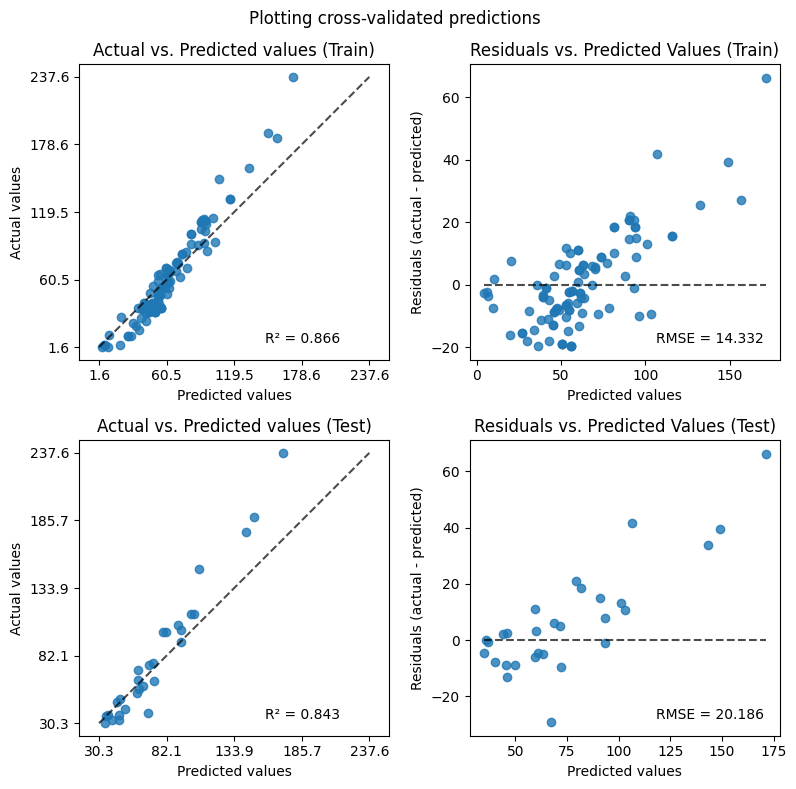

In [11]:
# Display cross validation
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axs = axs.flatten()

PredictionErrorDisplay.from_predictions(
    pd.Series(y_train),
    y_pred=pd.Series(y_pred_train),
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0)
axs[0].set_title("Actual vs. Predicted values (Train)")
axs[0].annotate(
    f"R² = {R2_train:.3f}",
     (0.6,0),(0,20),
    xycoords='axes fraction', textcoords='offset points', va='top')
PredictionErrorDisplay.from_predictions(
    pd.Series(y_train),
    y_pred=pd.Series(y_pred_train),
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0)
axs[1].set_title("Residuals vs. Predicted Values (Train)")
axs[1].annotate(
    f"RMSE = {RMSE_train:.3f}",
     (0.6,0),(0,20),
    xycoords='axes fraction', textcoords='offset points', va='top')
PredictionErrorDisplay.from_predictions(
    pd.Series(y_test),
    y_pred=pd.Series(y_pred_test),
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[2],
    random_state=0)
axs[2].set_title("Actual vs. Predicted values (Test)")
axs[2].annotate(
    f"R² = {R2_test:.3f}",
     (0.6,0),(0,20),
    xycoords='axes fraction', textcoords='offset points', va='top')
PredictionErrorDisplay.from_predictions(
    pd.Series(y_test),
    y_pred=pd.Series(y_pred_test),
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[3],
    random_state=0)
axs[3].set_title("Residuals vs. Predicted Values (Test)")
axs[3].annotate(
    f"RMSE = {RMSE_test:.3f}",
     (0.6,0),(0,20),
    xycoords='axes fraction', textcoords='offset points', va='top')

fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

Predicting the whole image using the fitted model

In [12]:
# # Predicting raster
# biomass_pred = regr.predict(predictor)

# # Reshape array to raster dimension
# regression = biomass_pred.reshape((rows,cols))

###Clustering
Clustering the regression image

In [13]:
# # Reshape the 2D regression result into a 1D array for KMeans
# regression_flat = regression.flatten().reshape(-1, 1)

# # Define the number of clusters
# # You can change this value to explore different numbers of clusters
# n_clusters = 5

# # Initialize and fit KMeans
# kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
# cluster_labels_flat = kmeans.fit_predict(regression_flat)

# # Reshape the cluster labels back to the original raster dimensions
# cluster_image = cluster_labels_flat.reshape((rows, cols))

###Display
Display result of biomass prediction and image clustering

In [14]:
# # Set Extent Parameter as Display the result
# ulx, xres, _, uly, _, yres = geo_transform
# extent = [ulx, ulx+xres*cols, uly, uly+yres*rows]

In [15]:
# # Visualize the Regression result
# plt.figure(figsize=(8, 8))
# plt.imshow(regression, cmap="RdYlGn", extent=extent)
# plt.colorbar(label="Ton-C/ha", shrink=0.5)
# plt.title("Carbon-AGB")
# plt.show()

In [16]:
# # Visualize the clustered result
# plt.figure(figsize=(8, 8))
# plt.imshow(cluster_image, cmap='viridis', extent=extent)
# plt.colorbar(label='Cluster ID', shrink=0.5)
# plt.title(f'KMeans Clustering of Carbon-AGB (k={n_clusters})')
# plt.show()

###Exporting
Export result as a geotiff. the result will be stored in Google Drive as the output file path paramaters setted

In [17]:
# Create Function for transform array to geotiff raster
def createGeotiff(outRaster, data, geo_transform, projection):
    # Create a GeoTIFF file with the given data
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    rasterDS = driver.Create(outRaster, cols, rows, 1, gdal.GDT_Float64)
    rasterDS.SetGeoTransform(geo_transform)
    rasterDS.SetProjection(projection)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(data)
    rasterDS = None

# # export classified image
# createGeotiff(outRaster,regression,geo_transform,projection)
# createGeotiff(outCluster,cluster_image,geo_transform,projection)